In [5]:


import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from scipy.optimize import curve_fit
from pathlib import Path

# Local modules
import data_organizer as do
from calculator import Calculator, exponential_ansatz, cornell_potential_ansatz
import load_input_yaml as liy

# Setup plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [6]:
# --- CONFIGURATION ---

# 1. Data Path (Change this to the DIRECTORY containing your .out files)
# Example: "../data/20251221/45" 
FILE_PATH = "../data/20260205/36"

# 2. Analysis Parameters
THERMALIZATION_STEPS = 500
SOMMER_TARGET_FORCE = 1.65

# 3. Fitting Parameters
V_R_T_MIN = 1          # Start time for V(R) fits
R0_T_MIN = 2           # t_min parameter passed to r0 calculation (if used)
R0_CHI_T_LARGE = 4     # Large T for Creutz ratio force extraction
CHI_FIT_WINDOW = 2     # Window size for r0_chi interpolation

print(f"Analyzing Directory: {FILE_PATH}")
print(f"Parameters: Therm={THERMALIZATION_STEPS}, Target={SOMMER_TARGET_FORCE}")

Analyzing Directory: ../data/20260205/36
Parameters: Therm=500, Target=1.65


# Potential V(R)

In [7]:
# --- 1. Load Data and Initialize Calculator ---

try:
    # Initialize Experiment Data
    experiment = do.ExperimentData(FILE_PATH)
    
    if "W_temp" not in experiment.data or not experiment.data["W_temp"]:
        print("Error: No 'W_temp.out' file found in the directory.")
    else:
        # Get the first W_temp file (assuming only one usually or we take the first)
        w_temp_data = experiment.data["W_temp"][0]
        
        print(f"Loaded W_temp data with {len(w_temp_data.observables[0].values)} entries (after thermalization cut if applied).")

        calc = Calculator(w_temp_data, n_bootstrap=50, step_size=1)
        print("Calculator initialized.")

except Exception as e:
    print(f"An error occurred loading data: {e}")


Loaded W_temp data with 4239894 entries (after thermalization cut if applied).
Calculator initialized.


Plotting W(R,T) fits for R = [2, 4, 6, 8]


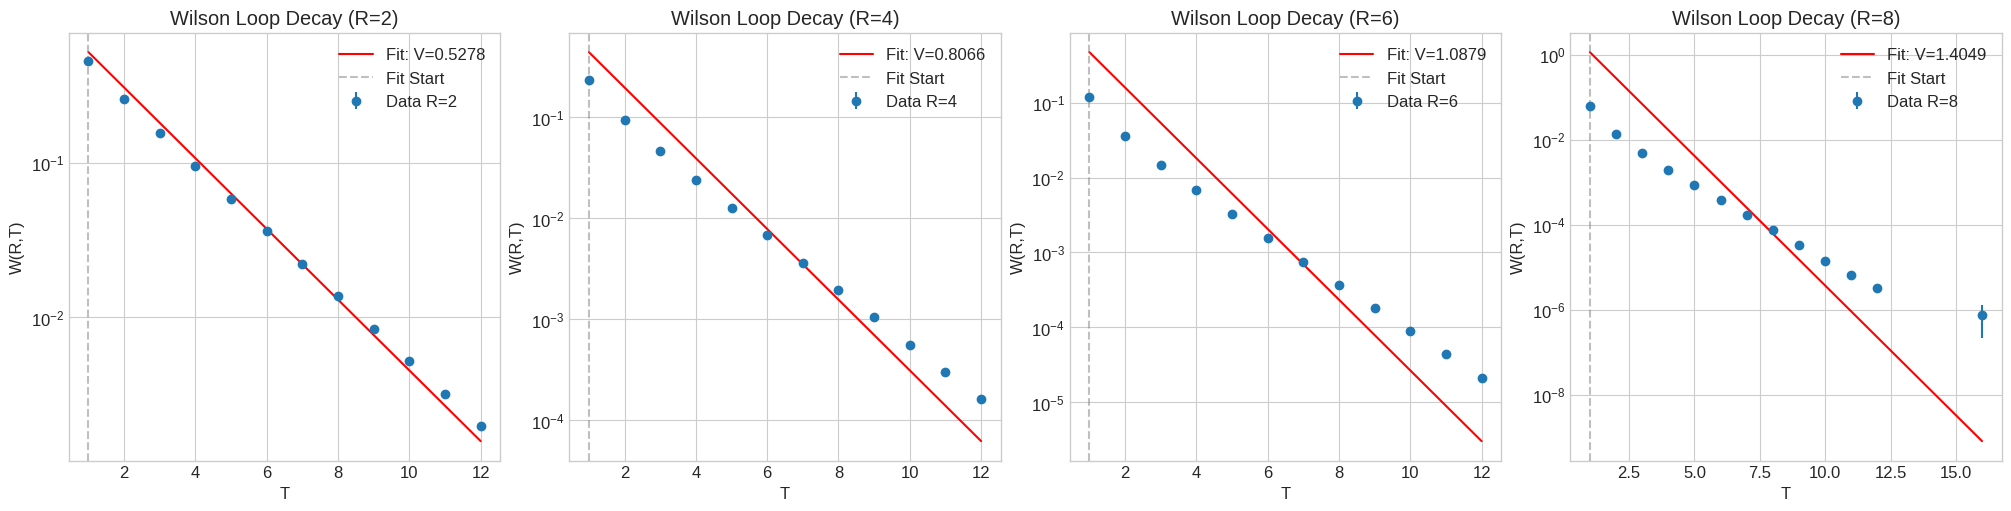

In [ ]:
# --- 2. Plot W(R, T) vs T (Step 1: Extracting V(R)) ---

# Identify available R values (L column in W_temp)
try:
    all_L = np.array(w_temp_data.get("L").values)
    unique_Rs = sorted(np.unique(all_L))
    
    # Pick a few representative R values to plot
    # e.g., smallest, middle, largest
    r_to_plot = [unique_Rs[0], unique_Rs[len(unique_Rs)//2], unique_Rs[-1]]
    if len(unique_Rs) > 3:
        # Maybe pick explicitly R=2, 4, 6 if available
        candidates = [2, 4, 6, 8]
        r_to_plot = [r for r in candidates if r in unique_Rs]
        if not r_to_plot: r_to_plot = unique_Rs[:3]

    print(f"Plotting W(R,T) fits for R = {r_to_plot}")

    fig, axes = plt.subplots(1, len(r_to_plot), figsize=(5*len(r_to_plot), 5), constrained_layout=True)
    if len(r_to_plot) == 1: axes = [axes]

    for ax, r_val in zip(axes, r_to_plot):
        # 1. Get W(R, T) data points
        # We need to query T values for this R
        all_T = np.array(w_temp_data.get("T").values)
        unique_Ts = sorted(np.unique(all_T[all_L == r_val]))
        
        ws, ws_err, ts = [], [], []
        
        for t_val in unique_Ts:
            try:
                # W_R_T calculator retrieves the mean and error for W(R,T)
                w_var = calc.get_variable("W_R_T", R=r_val, T=t_val)
                ws.append(w_var.get())
                ws_err.append(w_var.err() if w_var.err() else 0)
                ts.append(t_val)
            except Exception:
                continue
                
        # Filter negative or zero values for log plot
        ts = np.array(ts)
        ws = np.array(ws)
        ws_err = np.array(ws_err)
        
        mask = ws > 0
        ts_fit = ts[mask]
        ws_fit = ws[mask]
        ws_err_fit = ws_err[mask]
        
        # Plot Data Points
        ax.errorbar(ts_fit, ws_fit, yerr=ws_err_fit, fmt='o', label=f'Data R={r_val}')
        
        # 2. Get V(R) result from Calculator
        # This is the "slope" extracted by the calculator
        try:
            v_var = calc.get_variable("V_R", R=r_val, t_min=V_R_T_MIN)
            v_val = v_var.get()
            
            # Retrieve C directly from calculator
            C_est = v_var.parameters.get("fit_C", None)
            
            if not np.isnan(v_val):
                if C_est is None:
                    # Fallback if fit_C is missing (should not happen with new calculator)
                    mask_t = ts_fit >= V_R_T_MIN
                    if np.any(mask_t):
                        ln_ws = np.log(ws_fit[mask_t])
                        ts_subset = ts_fit[mask_t]
                        ln_C_vals = ln_ws + v_val * ts_subset
                        ln_C = np.mean(ln_C_vals)
                        C_est = np.exp(ln_C)
                    else:
                        C_est = 1.0

                # Generate line points
                t_line = np.linspace(min(ts_fit), max(ts_fit), 100)
                w_line = C_est * np.exp(-v_val * t_line)
                
                ax.plot(t_line, w_line, 'r-', label=f'Fit: V={v_val:.4f}')
                
                # Highlight fit region start
                ax.axvline(V_R_T_MIN, color='gray', linestyle='--', alpha=0.5, label='Fit Start')

        except Exception as e:
            print(f"Could not get V_R for R={r_val}: {e}")

        ax.set_yscale('log')
        ax.set_title(f"Wilson Loop Decay (R={r_val})")
        ax.set_xlabel("T")
        ax.set_ylabel("W(R,T)")
        ax.legend()

    plt.show()

except Exception as e:
    print(f"Error in plotting W(R,T): {e}")

In [ ]:
# --- 3. Plot V(R) vs R and Cornell Fit (Step 2: Calculating r0) ---

try:
    # 1. Calculate r0 and get fit parameters
    # The default t_min in calculator is 2, but we use R0_T_MIN from config
    r0_var = calc.get_variable("r0", t_min=R0_T_MIN, target_force=SOMMER_TARGET_FORCE)
    r0_val = r0_var.get()
    
    # Extract Cornell Parameters from the result
    # The variable stores these in its parameters dict
    cornell_params = r0_var.parameters.get("cornell_params", None)
    
    print(f"Calculated r0: {r0_val}")
    if cornell_params:
        print(f"Cornell Parameters: {cornell_params}")
    else:
        print("Warning: Cornell parameters not found in r0 variable.")

    # 2. Collect V(R) points for plotting
    # We must use the same t_min as used in r0 calculation
    rs = []
    vs = []
    vs_err = []
    
    for r_val in unique_Rs:
        try:
            v_var = calc.get_variable("V_R", R=r_val, t_min=R0_T_MIN)
            val = v_var.get()
            err = v_var.err()
            
            if not np.isnan(val):
                rs.append(r_val)
                vs.append(val)
                vs_err.append(err if err is not None else 0)
        except Exception:
            continue
            
    # 3. Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot V(R) Points
    ax.errorbar(rs, vs, yerr=vs_err, fmt='o', label='V(R) Data', zorder=5)
    
    # Plot Cornell Fit Curve
    if cornell_params:
        A = cornell_params['A']
        sigma = cornell_params['sigma']
        B = cornell_params['B']
        
        # Smooth line for plotting
        r_line = np.linspace(min(rs), max(rs), 100)
        v_line = cornell_potential_ansatz(r_line, A, sigma, B)
        
        ax.plot(r_line, v_line, 'r-', label=f'Cornell Fit\nA={A:.2f}, sig={sigma:.2f}, B={B:.2f}')
        
        # Mark r0
        if not np.isnan(r0_val):
            # Calculate V(r0)
            v_r0 = cornell_potential_ansatz(r0_val, A, sigma, B)
            ax.plot(r0_val, v_r0, 'ks', markersize=8, label=f'$r_0/a$ = {r0_val:.3f}')
            # Draw lines to axes
            ax.axvline(r0_val, color='k', linestyle=':', alpha=0.5)
            # ax.axhline(v_r0, color='k', linestyle=':', alpha=0.5)

    ax.set_title(f"Static Potential V(R) and Cornell Fit (t_min={R0_T_MIN})")
    ax.set_xlabel("R/a")
    ax.set_ylabel("aV(R)")
    ax.legend()
    plt.show()

except Exception as e:
    print(f"Error in plotting V(R): {e}")


### Explanation of Plots

1. **Wilson Loop Decay**: The first set of plots shows how the Wilson Loop $W(R,T)$ decays with time $T$. The slope of the exponential decay (in the log-linear plot) gives the static potential $V(R)$.
   - We fit $W(R,T) \sim C e^{-V(R)T}$.
   - The red line shows the fit result using the extracted $V(R)$.

2. **Static Potential & Cornell Fit**: The second plot shows the extracted potential values $V(R)$ plotted against spatial separation $R$.
   - We fit these points to the Cornell Potential: $V(R) = A + \sigma R - \frac{B}{R}$.
   - The Sommer parameter $r_0$ is then determined from this fit where the force $r^2 F(r) = 1.65$.
